<a href="https://colab.research.google.com/github/gabrielmaranhao/MOSFET_model/blob/main/Examples/SkyWater130/SkyWater130nm_ACM2V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Configure NGSPICE+OSDI and Skywater 130 nm  {display-mode: "form"}
#@markdown Takes around 10 minutes. It is necessary to compile ngspice directly,
#@markdown as only ngspice 39+ comes with OSDI option enabled.


#----------------Imports--------------------
#
#
from cmath import exp
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import os
import pathlib
import urllib.request
import pathlib
import sys
import csv
#
#
#------------------------------------------

!sudo apt-get update
#!sudo apt-get install -y ngspice build-essential
!sudo apt-get install -y libtool
!sudo apt-get install -y libxaw7-dev
!sudo apt-get install -y bison

!git clone https://git.code.sf.net/p/ngspice/ngspice ngspice

%cd /content/ngspice

!./autogen.sh
!./configure --with-x --disable-debug --enable-cider --with-readline=yes --enable-openmp --enable-osdi
!make
!sudo make install

import os
os.environ['PATH'] = '/usr/local/bin:' + os.environ['PATH']
!ngspice --version

%cd ..

#----------------Install OPENVAF - VerilogA compiler--------------------
#
#
!wget https://openva.fra1.cdn.digitaloceanspaces.com/openvaf_23_2_0_linux_amd64.tar.xz
!tar -xf openvaf_23_2_0_linux_amd64.tar.xz

os.environ['PATH'] += ":/content"

!chmod +x /content/openvaf
!rm -f openvaf_23_2_0_linux_amd64.tar.xz
#
#
#------------------------------------------------------------------------

#----------------Install SKY130nm dependencies--------------------
#
#
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a
#
#
#-------------------------------------------------------------------

A saída de streaming foi truncada nas últimas 5000 linhas.
Extracting   (1)  ⣾  [+] 5m:5.9s
Extracting   (1)  ⣾  [+] 5m:6.0s
Extracting   (1)  ⣾  [+] 5m:6.1s
Extracting   (1)  ⣾  [+] 5m:6.2s
Extracting   (1)  ⣾  [+] 5m:6.3s
Extracting   (1)  ⣾  [+] 5m:6.4s
Extracting   (1)  ⣾  [+] 5m:6.5s
Extracting   (1)  ⣾  [+] 5m:6.6s
Extracting   (1)  ⣾  [+] 5m:6.7s
Extracting   (1)  ⣾  [+] 5m:6.8s
Extracting   (1)  ⣾  [+] 5m:6.9s
Extracting   (1)  ⣾  [+] 5m:7.0s
Extracting   (1)  ⣾  [+] 5m:7.1s
Extracting   (1)  ⣾  [+] 5m:7.2s
Extracting   (1)  ⣾  [+] 5m:7.3s
Extracting   (1)  ⣾  [+] 5m:7.4s
Extracting   (1)  ⣾  [+] 5m:7.5s
Extracting   (1)  ⣾  [+] 5m:7.6s
Extracting   (1)  ⣾  [+] 5m:7.7s
Extracting   (1)  ⣾  [+] 5m:7.8s
Extracting   (1)  ⣾  [+] 5m:7.9s
Extracting   (1)  ⣾  [+] 5m:8.0s
Extracting   (1)  ⣾  [+] 5m:8.1s
Extracting   (1)  ⣾  [+] 5m:8.2s
Extracting   (1)  ⣾  [+] 5m:8.3s
Extracting   (1)  ⣾  [+] 5m:8.4s
Extracting   (1)  ⣾  [+] 5m:8.5s
Extracting   (1)  ⣾  [+] 5m:8.6s
Extracting   (1) 

In [2]:
#@title Run OPENVAF - generate OSDI files from Verilog files
#OpenVAF version: openvaf_23_5_0_linux_amd64.tar.xz
#From: https://openvaf.semimod.de/

#get .va files
!git clone https://github.com/ACMmodel/MOSFET_model.git
!cp MOSFET_model/Verilog-A/NMOS_ACM_2V0.va /content/
!cp MOSFET_model/Verilog-A/PMOS_ACM_2V0.va /content/

#Insert ".va" file path
!openvaf NMOS_ACM_2V0.va
!openvaf PMOS_ACM_2V0.va

Cloning into 'MOSFET_model'...
remote: Enumerating objects: 293, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 293 (delta 90), reused 116 (delta 47), pack-reused 87
Receiving objects: 100% (293/293), 3.43 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Finished building NMOS_ACM_2V0.va in 0.44s
Finished building PMOS_ACM_2V0.va in 0.31s


In [ ]:
%%writefile .spiceinit
set ngbehavior=hs

Writing .spiceinit


In [ ]:
#@title NETLIST Example 1
%%writefile example1.spice

* model definitions:

* model definitions:
.model NMOS_ACM nmos_ACM
.lib "conda-env/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt

VG1 g1 0 DC 0
VS1 s1 0 DC 0
VB1 b1 0 DC 0
VD1 d1 0 DC 1.8

VS2 s2 0 DC 0
VB2 b2 0 DC 0
VD2 d2 0 DC 1.8

*Sky130nm
*connections:
*   drain
*   |  gate
*   |  |  source
*   |  |  |  bulk
*   |  |  |  |
xm1 d1 g1 s1 b1 sky130_fd_pr__nfet_01v8 l=0.25 w=3

*OSDI ACM 5PM:
*connections:
*  drain
*  |  gate
*  |  |  source
*  |  |  |  bulk
*  |  |  |  |
N1 d2 g1 s2 b2 NMOS_ACM W=3u L=0.25u n=1.463 IS=1.9143u VT0=0.719 sigma=0.0173 zeta=0.0113

.control
pre_osdi NMOS_ACM_2V0.osdi

dc VG1 0.0 1.8 5m

wrdata example1_out.txt i(VS1) i(VS2)

.endc

.end

Overwriting example1.spice



Note: Compatibility modes selected: hs



Circuit: 

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  0.00000e+00
No. of Data Rows : 361
Note: Simulation executed from .control section 





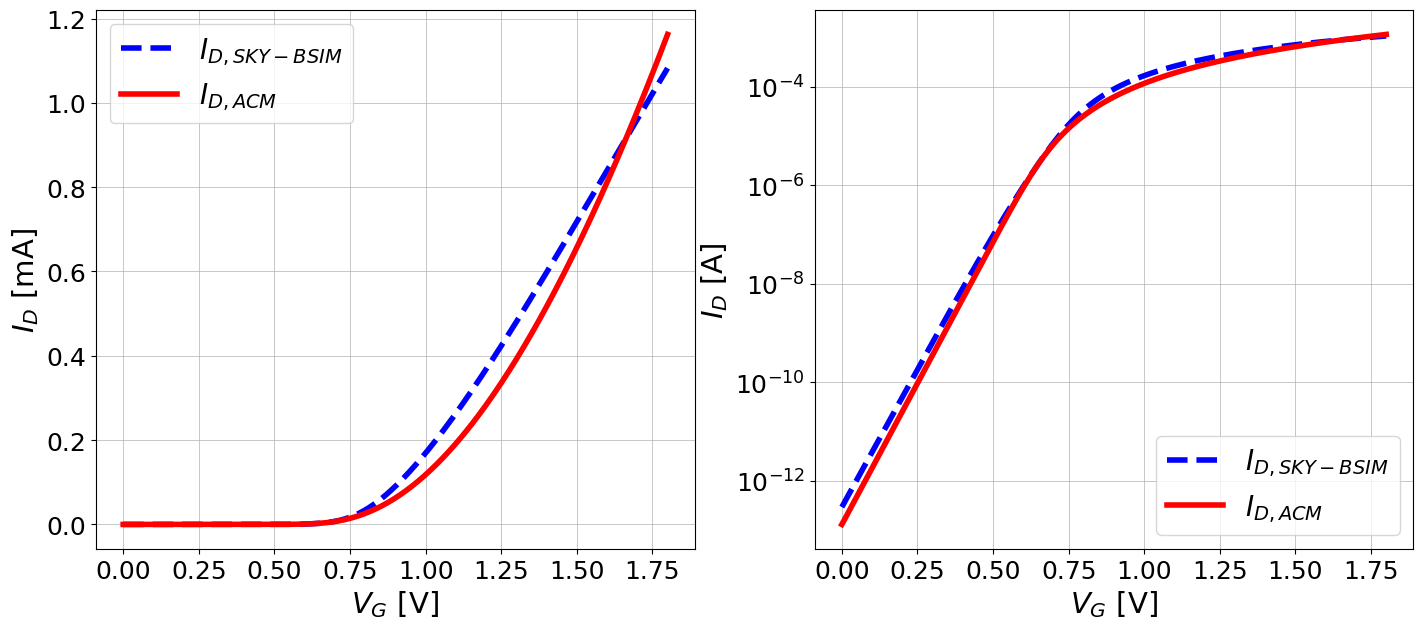

In [ ]:
#@title Run Example 1

!ngspice -b example1.spice ## Run ngspice

print()
print()
print()

data_ex1 = pd.read_csv("example1_out.txt", delim_whitespace=True, header=None)


data_ex1.columns = ["vg", "id_sky","null","id_acm"]
vg_nmos = data_ex1['vg']

#Creating figure
fig, ax1 = plt.subplots(1,2,figsize=(17, 7))
#ax2 = ax1.twinx()

ax1[0].plot(data_ex1['vg'],data_ex1['id_sky']*10**(3),'b--',linewidth=4,label='$I_{D,SKY-BSIM}$')
ax1[0].plot(data_ex1['vg'],data_ex1['id_acm']*10**(3),'r',linewidth=4,label='$I_{D,ACM}$')

ax1[1].semilogy(data_ex1['vg'],data_ex1['id_sky'],'b--',linewidth=4,label='$I_{D,SKY-BSIM}$')
ax1[1].semilogy(data_ex1['vg'],data_ex1['id_acm'],'r',linewidth=4,label='$I_{D,ACM}$')


#Labels
#ax1[0].set_title('NMOS-> $I_{D}$ vs. $V_{G}$')
#ax1[0].title.set_fontsize(20)

ax1[0].set_xlabel('$V_{G}$ [V]',fontsize=21)
ax1[0].set_ylabel('$I_{D}$ [mA]',fontsize=21)

ax1[1].set_xlabel('$V_{G}$ [V]',fontsize=21)
ax1[1].set_ylabel('$I_{D}$ [A]',fontsize=21)



# X and Y axis tick font size
for label in (ax1[0].get_xticklabels() + ax1[0].get_yticklabels()):
	label.set_fontsize(18)

for label in (ax1[1].get_xticklabels() + ax1[1].get_yticklabels()):
	label.set_fontsize(18)

#grid
ax1[0].grid(linewidth=0.5)
ax1[0].legend(loc=2,fontsize=20)

ax1[1].grid(linewidth=0.5)
ax1[1].legend(loc=4,fontsize=20)
